# Survival Regression with `estimators.SurvivalModel`
<hr>

Author: ***Willa Potosnak***  &lt;wpotosna@andrew.cmu.edu&gt;

<div style=" float: right;">
<img align="right" src="https://ndownloader.figshare.com/files/34052981" width="25%"/>
<img align="right" src="https://www.cs.cmu.edu/~chiragn/auton_logo.png" width="25%"/>
</div>

# Contents


### 1. [Introduction](#introduction) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.1 [The SUPPORT Dataset](#support)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;  1.2 [Preprocessing the Data](#preprocess)

### 2. [Cox Proportional Hazards (CPH)](#cph) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.1 [Fit CPH Model](#fitcph)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   2.2 [Evaluate CPH Model](#evalcph)

### 3. [Deep Cox Proportional Hazards (DCPH)](#fsn) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.1 [Fit DCPH Model](#fitfsn)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   3.2 [Evaluate DCPH Model](#evalfsn)

### 4. [Deep Survival Machines (DSM)](#dsm) 
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.1 [Fit DSM Model](#fitdsm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   4.2 [Evaluate DSM Model](#evaldsm)

### 5. [Deep Cox Mixtures (DCM)](#dcm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   5.1 [Fit DCM Model](#fitdcm)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   5.2 [Evaluate DCM Model](#evaldcm)

### 6. [Random Survival Forests (RSF)](#rsf)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   6.1 [Fit RSF Model](#fitrsf)
####   &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;   6.2 [Evaluate RSF Model](#evalrsf)

<hr>

<a id="introduction"></a>

## 1. Introduction

The `SurvivalModels` class offers a steamlined approach to train two `auton-survival` models and three baseline survival models for right-censored time-to-event data. The fit method requires the same inputs across all five models, however, model parameter types vary and must be defined and tuned for the specified model.

### Native `auton-survival` Models

* **Faraggi-Simon Net (FSN)/DeepSurv**
* **Deep Survival Machines (DSM)** 
* **Deep Cox Mixtures (DCM)**

### External Models

* **Random survival Forests (RSF)**
* **Cox Proportional Hazards (CPH)**

 
$\textbf{Hyperparameter tuning}$ and $\textbf{model evaluation}$ can be performed using the following metrics, among others.

* $\textbf{Brier Score (BS)}$: the Mean Squared Error (MSE) around the probabilistic prediction at a certain time horizon. The Brier Score can be decomposed into components that measure both discriminative performance and calibration.

\begin{align}
\text{BS}(t) = \mathop{\mathbf{E}}_{x\sim\mathcal{D}}\big[ ||\mathbf{1}\{ T > t \} - \widehat{\mathbf{P}}(T>t|X)\big)||_{_\textbf{2}}^\textbf{2}  \big]
\end{align}

* $\textbf{Integrated Brier Score (IBS)}$: the integral of the time-dependent $\textbf{BS}$ over the interval $[t_1; t_{max}]$ where the weighting function is $w(t)= \frac{t}{t_{max}}$.

\begin{align}
\text{IBS} = \int_{t_1}^{t_{max}} \mathrm{BS}^{c}(t)dw(t)
\end{align}

* $\textbf{Area under ROC Curve (ROC-AUC)}$: survival model evaluation can be treated as binary classification to compute the **True Positive Rate (TPR)** and **False Positive Rate (FPR)** dependent on time, $t$. ROC-AUC is used to assess how well the model can distinguish samples that fail by a given time, $t$ from those that fail after this time.

\begin{align}
\widehat{AUC}(t) = \frac{\sum_{i=1}^{n} \sum_{j=1}^{n}I(y_j>t)I(y_i \leq t)w_iI(\hat{f}(x_j) \leq \hat{f}(x_i))}{(\sum_{i=1}^{n} I(y_i > t))(\sum_{i=1}^{n}I(y_i \leq t)w_i)}
\end{align}

* $\textbf{Time Dependent Concordance Index (C$^{td}$)}$: estimates ranking ability by exhaustively comparing relative risks across all pairs of individuals in the test set. We employ the ‘Time Dependent’ variant of Concordance Index that truncates the pairwise comparisons to the events occurring within a fixed time horizon. 

\begin{align}
C^{td}(t) = P(\hat{F}(t|x_i) > \hat{F} (t|x_j)|\delta_i = 1, T_i < T_j, T_i \leq t)
\end{align}


<a id="support"></a>

### 1.1. The SUPPORT Dataset

*For the original datasource, please refer to the following [website](https://biostat.app.vumc.org/wiki/Main/SupportDesc).*

Data features $x$ are stored in a pandas dataframe with rows corresponding to individual samples and columns as covariates. Data outcome consists of 'time', $t$, and 'event', $e$, that correspond to the time to event and the censoring indicator, respectively. 

In [ ]:
import pandas as pd
import sys
sys.path.append('../')

from auton_survival.datasets import load_dataset

In [ ]:
# Load the SUPPORT dataset
outcomes, features = load_dataset(dataset='SUPPORT')

# Identify categorical (cat_feats) and continuous (num_feats) features
cat_feats = ['sex', 'dzgroup', 'dzclass', 'income', 'race', 'ca']
num_feats = ['age', 'num.co', 'meanbp', 'wblc', 'hrt', 'resp', 
             'temp', 'pafi', 'alb', 'bili', 'crea', 'sod', 'ph', 
             'glucose', 'bun', 'urine', 'adlp', 'adls']

# Let's take a look at the features
display(features.head(5))

# Let's take a look at the outcomes
display(outcomes.head(5))

<a id="preprocess"></a>
### 1.2. Preprocess the Data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Split the SUPPORT data into training, validation, and test data
x_tr, x_te, y_tr, y_te = train_test_split(features, outcomes, test_size=0.2, random_state=1)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, test_size=0.25, random_state=1) 

print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
print(f'Number of test data points: {len(x_te)}')

In [ ]:
from auton_survival.preprocessing import Preprocessor

# Fit the imputer and scaler to the training data and transform the training, validation and test data
preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat= 'mean') 
transformer = preprocessor.fit(features, cat_feats=cat_feats, num_feats=num_feats,
                                one_hot=True, fill_value=-1)
x_tr = transformer.transform(x_tr)
x_val = transformer.transform(x_val)
x_te = transformer.transform(x_te)

<a id="cph"></a>
## 2. Cox Proportional Hazards (CPH) 

<b>CPH</b> [2]  model assumes that individuals across the population have constant proportional hazards overtime. In this model, the estimator of the survival function conditional on $X, S(·|X) , P(T > t|X)$, is assumed to have constant proportional hazard. Thus, the relative proportional hazard between individuals is constant across time.

*For full details on CPH, please refer to the following paper*:

[2] [Cox, D. R. (1972). Regression models and life-tables. Journal of the Royal Statistical Society: Series B (Methodological).](https://www.jstor.org/stable/2985181)

<a id="fitcph"></a>
### 2.1. Fit CPH Model


In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'l2' : [1e-3, 1e-4]}
params = ParameterGrid(param_grid)

# Define the times for model evaluation
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('cph', random_seed=2, l2=param['l2'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

<a id="evalcph"></a>
### 2.2. Evaluate CPH Model


In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

<a id="fsn"></a>
## 3. Deep Cox Proportional Hazards (DCPH)

<b>DCPH</b> [2], [3] is an extension to the CPH model. DCPH involves modeling the proportional hazard ratios over the individuals with Deep Neural Networks allowing the ability to learn non linear hazard ratios.

*For full details on DCPH models, Faraggi-Simon Net (FSN) and DeepSurv, please refer to the following papers*:

[2] [Faraggi, David, and Richard Simon. "A neural network model for survival data." Statistics in medicine 14.1 (1995): 73-82.](https://onlinelibrary.wiley.com/doi/abs/10.1002/sim.4780140108)

[3] [Katzman, Jared L., et al. "DeepSurv: personalized treatment recommender system using a Cox proportional hazards deep neural network." BMC medical research methodology 18.1 (2018): 1-12.](https://arxiv.org/abs/1606.00931v3)

<a id="fitfsn"></a>
### 3.1. Fit DCPH Model

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'bs' : [100, 200],
              'learning_rate' : [ 1e-4, 1e-3],
              'layers' : [ [100], [100, 100] ]
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dcph', random_seed=0, bs=param['bs'], learning_rate=param['learning_rate'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

<a id="evalfsn"></a>
### 3.2. Evaluate DCPH Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

<a id="dsm"></a>
## 4. Deep Survival Machines (DSM)

<b>DSM</b> [5] is a fully parametric approach to modeling the event time distribution as a fixed size mixture over Weibull or Log-Normal distributions. The individual mixture distributions are parametrized with neural networks to learn complex non-linear representations of the data.

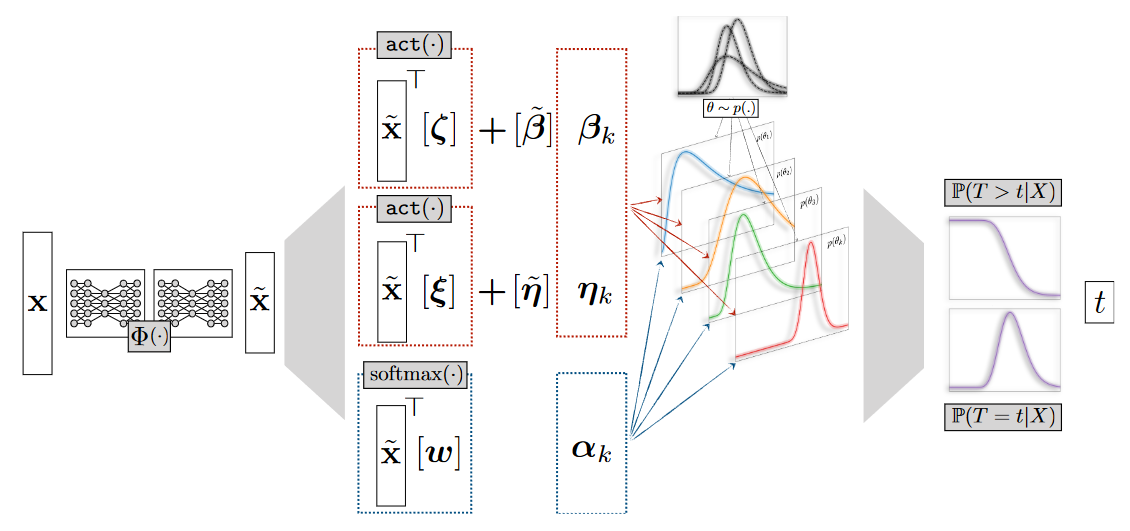


<b>Figure A:</b> DSM works by modeling the conditional distribution $P(T |X = x)$ as a mixture over $k$ well-defined, parametric distributions. DSM generates representation of the individual covariates, $x$, using a deep multilayer perceptron followed by a softmax over mixture size, $k$. This representation then interacts with the additional set of parameters,  to determine the mixture weights $w$ and the parameters of each of $k$ underlying survival distributions $\{\eta_k, \beta_k\}^K_{k=1}$. The final individual survival distribution for the event time, $T$, is a weighted average over these $K$ distributions.


*For full details on Deep Survival Machines (DSM), please refer to the following paper*:

[5] [Chirag Nagpal, Xinyu Li, and Artur Dubrawski. Deep survival machines: Fully parametric survival regression and representation learning for censored data with competing risks. 2020.](https://arxiv.org/abs/2003.01176)


<a id="fitdsm"></a>
### 4.1. Fit DSM Model

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'layers' : [[100], [100, 100], [200]],
              'distribution' : ['Weibull', 'LogNormal'],
              'max_features' : ['sqrt', 'log2']
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dsm', random_seed=0, layers=param['layers'], distribution=param['distribution'], max_features=param['max_features'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

<a id="evaldsm"></a>
### 4.2. Evaluate DSM Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

<a id="dcm"></a>
## 5. Deep Cox Mixtures (DCM)

<b>DCM</b> [2] generalizes the proportional hazards assumption via a mixture model, by assuming that there are latent groups and within each, the proportional hazards assumption holds. DCM allows the hazard ratio in each latent group, as well as the latent group membership, to be flexibly modeled by a deep neural network.

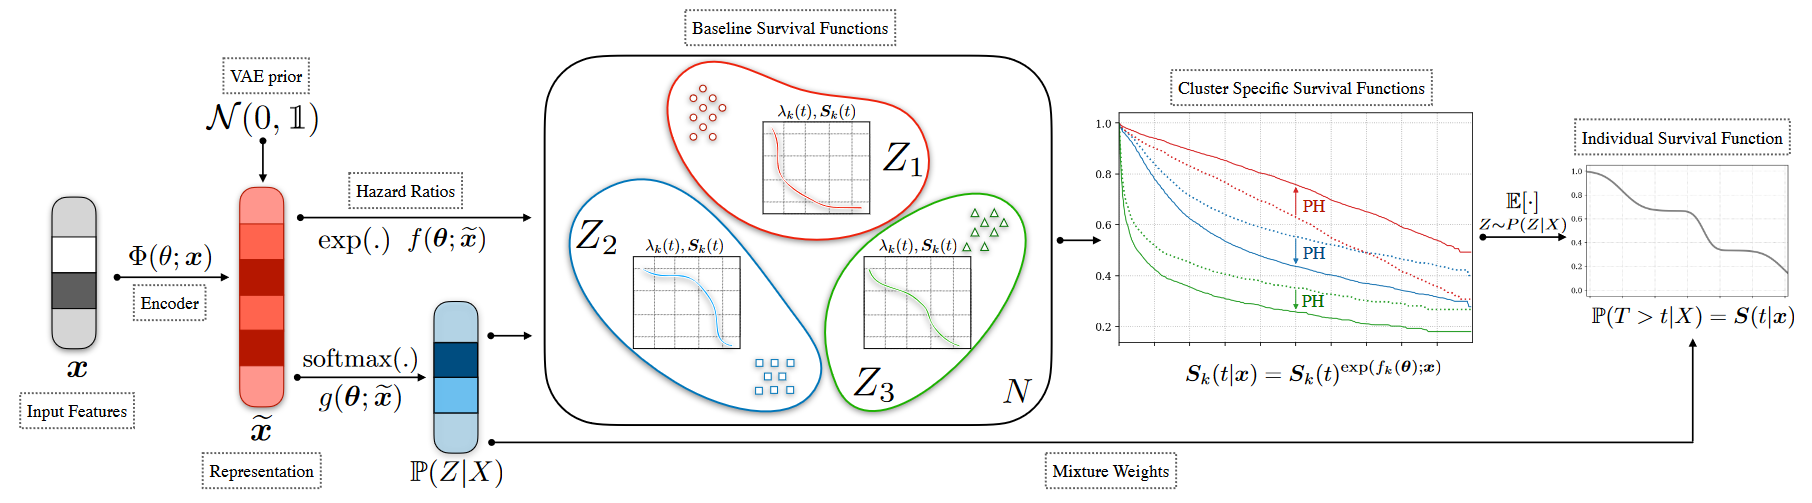

<b>Figure B:</b> DCM works by generating representation of the individual covariates, $x$, using an encoding neural network. The output representation, $xe$, then interacts with linear functions, $f$ and $g$, that determine the proportional hazards within each cluster $Z ∈ {1, 2, ...K}$ and the mixing weights $P(Z|X)$ respectively. For each cluster, baseline survival rates $Sk(t)$ are estimated non-parametrically. The final individual survival curve $S(t|x)$ is an average over the cluster specific individual survival curves weighted by the mixing probabilities $P(Z|X = x)$.


*For full details on Deep Cox Mixtures (DCM), please refer to the following paper*:

[2] [Nagpal, C., Yadlowsky, S., Rostamzadeh, N., and Heller, K. (2021c). Deep cox mixtures for survival regression. In
Machine Learning for Healthcare Conference, pages 674–708. PMLR.](https://arxiv.org/abs/2101.06536)

<a id="fitdcm"></a>
### 5.1. Fit DCM Model

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'k' : [2, 3],
              'learning_rate' : [1e-3, 1e-4],
              'layers' : [[100], [100, 100]]
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('dcm', random_seed=7, k=param['k'], learning_rate=param['learning_rate'], layers=param['layers'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

<a id="evaldcm"></a>
### 5.2. Evaluate DCM Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)

<a id="rsf"></a>
## 6. Random Survival Forests (RSF)

<b>RSF</b> [4] is an extension of Random Forests to the survival settings where risk scores are computed by creating Nelson-Aalen estimators in the splits induced by the Random Forest.

We observe that performance of the Random Survival Forest model, especially in terms of calibration is strongly influenced by the choice for the hyperparameters for the number of features considered at each split and the minimum number of data samples to continue growing a tree. We thus advise carefully tuning these hyper-parameters while benchmarking RSF.

*For full details on Random Survival Forests (RSF), please refer to the following paper*:

[4] [Hemant Ishwaran et al. Random survival forests. The annals of applied statistics, 2(3):841–860, 2008.](https://arxiv.org/abs/0811.1645)

<a id="fitrsf"></a>
### 6.1. Fit RSF Model

In [ ]:
from auton_survival.estimators import SurvivalModel
from auton_survival.metrics import survival_regression_metric
from sklearn.model_selection import ParameterGrid

# Define parameters for tuning the model
param_grid = {'n_estimators' : [100, 300],
              'max_depth' : [3, 5],
              'max_features' : ['sqrt', 'log2']
             }

params = ParameterGrid(param_grid)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event']==1], np.linspace(0.1, 1, 10)).tolist()

# Perform hyperparameter tuning 
models = []
for param in params:
    model = SurvivalModel('rsf', random_seed=8, n_estimators=param['n_estimators'], max_depth=param['max_depth'], max_features=param['max_features'])
    
    # The fit method is called to train the model
    model.fit(x_tr, y_tr)

    # Obtain survival probabilities for validation set and compute the Integrated Brier Score 
    predictions_val = model.predict_survival(x_val, times)
    metric_val = survival_regression_metric('ibs', y_val, predictions_val, times, y_tr)
    models.append([metric_val, model])
    
# Select the best model based on the mean metric value computed for the validation set
metric_vals = [i[0] for i in models]
first_min_idx = metric_vals.index(min(metric_vals))
model = models[first_min_idx][1]

<a id="evalrsf"></a>
### 6.2. Evaluate RSF Model

Compute the Brier Score and time-dependent concordance index for the test set. See notebook introduction for more details.

In [ ]:
from estimators_demo_utils import plot_performance_metrics

# Obtain survival probabilities for test set
predictions_te = model.predict_survival(x_te, times)

# Compute the Brier Score and time-dependent concordance index for the test set to assess model performance
results = dict()
results['Brier Score'] = survival_regression_metric('brs', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
results['Concordance Index'] = survival_regression_metric('ctd', outcomes=y_te, predictions=predictions_te, 
                                                    times=times, outcomes_train=y_tr)
plot_performance_metrics(results, times)